La idea es resolver la ecucion diferencial, con sus condiciones de borde, y el problema de autovalores.

$$
\begin{aligned}
-y''(x) = \lambda\, y(x) \\ \quad x \in (0,L) \\
y'(0) = 0\\ \quad y(L) = 0
\end{aligned}
$$


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

M = 5  # número de modelos a entrenar
N = 200
l = 1.0
lr = 1e-3
layers = 2
neuronas = 20
epocs = 50_000

cuda


In [ ]:
# Activación 
class FunAct(nn.Module):
    def forward(self, r):
        return torch.tanh(r)

# Red 
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=neuronas, depth=layers):
        super().__init__()
        self.Lin_E = torch.nn.Linear(1, 1)
        capas = [nn.Linear(in_dim, width), FunAct()]
        for _ in range(depth - 1):
            capas += [nn.Linear(width, width), FunAct()]
        capas += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*capas)

    def forward(self, r, a=0):
        E_tr = self.Lin_E(torch.ones_like(r))
        E_tr = -torch.abs(E_tr)
        return self.net(torch.cat((r, E_tr), 1)), E_tr

In [ ]:
def D(y, x):
    return torch.autograd.grad(y, x, torch.ones_like(y),
                               retain_graph=True, create_graph=True)[0]

def EDP(U, E, r):
    U_r = D(U, r)
    U_rr = D(U_r, r)
    return U_rr + U * E

def muestreo(N):
    x = torch.rand(N, 1, device=device) * l
    return x.requires_grad_(True)

def weights_init(m):
    if isinstance(m, nn.Linear) and m.weight.shape[0] != 1:
        torch.nn.init.xavier_uniform_(m.weight.data)

In [ ]:
def train(u, x_g, l, c=0):
    u.apply(weights_init)
    torch.nn.init.uniform_(u.Lin_E.weight.data, a=0.0, b=1.0)

    optimizer = torch.optim.Adam(u.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=300)

    loss_vals, E_hist = [], []
    t0_clock = time.time()

    # pesos 
    w_pde = 1.0
    w_bc = 1.0
    w_norm = 1.0
    w_rayleigh = 2.0

    for step in range(epocs):
        optimizer.zero_grad(set_to_none=True)

        # puntos interiores
        U_poblado, E = u(x_g)
        residuo = EDP(U_poblado, E, x_g)

        # condiciones de borde
        x0 = torch.zeros((1,1), device=device, dtype=x_g.dtype).requires_grad_(True)
        xl = torch.full((1,1), float(l), device=device, dtype=x_g.dtype).requires_grad_(True)
        U0, _ = u(x0)
        U0_x = D(U0, x0)

        # normalizacion
        dx = l / N
        norm = torch.sqrt((U_poblado**2).mean())  # aproximación discreta
        L_norm = (norm - 1.0)**2

        # Rayleigh quotient
        U_r = D(U_poblado, x_g)
        U_rr = D(U_r, x_g)
        num = (U_poblado * (-U_rr) * dx).sum()
        den = (U_poblado**2 * dx).sum() + 1e-8
        R = num / den
        L_rayleigh = (E.mean() - R)**2

        # loss total
        L_pde = (residuo**2).mean()
        L_bc = (U0**2).mean() + (U0_x**2).mean()

        loss = (w_pde*L_pde + w_bc*L_bc + w_norm*L_norm + w_rayleigh*L_rayleigh)

        loss.backward()
        optimizer.step()
        scheduler.step(loss.item())

        loss_vals.append(loss.item())
        E_hist.append(E[0].item())

        if step % 500 == 0:
            mins = int((abs(t0_clock - time.time())*abs(epocs - step)/(step+1e-8))/60)
            print(f"|{c}| step {step:4d} | loss {loss.item():.3e} | "
                  f"E {E[0].item():.6f} | progreso {step*100/epocs:.1f}% | {mins} min restantes")

    return loss_vals, E_hist

In [ ]:
model = MLP().to(device)
r_g = muestreo(N)
r_vals = r_g.detach().cpu().numpy()

loses = []
E_historial = []
soluciones = []
energias = []

for j in range(M):
    L, En = train(model, r_g, l, c=j)
    loses.append(L)
    E_historial.append(En)
    soluciones.append(model(r_g)[0].cpu().detach().numpy())
    energias.append(model(r_g)[1].cpu().detach().numpy())
    model.apply(weights_init)

|0| step    0 | loss 1.567e+00 | E -0.199784 | progreso 0.0% | 1650472482 min restantes
|0| step  500 | loss 4.246e-01 | E -0.160211 | progreso 1.0% | 7 min restantes
|0| step 1000 | loss 4.078e-01 | E -0.387183 | progreso 2.0% | 7 min restantes
|0| step 1500 | loss 3.803e-01 | E -0.723415 | progreso 3.0% | 7 min restantes
|0| step 2000 | loss 3.426e-01 | E -1.213546 | progreso 4.0% | 7 min restantes
|0| step 2500 | loss 3.042e-01 | E -1.774316 | progreso 5.0% | 7 min restantes
|0| step 3000 | loss 2.670e-01 | E -2.356552 | progreso 6.0% | 7 min restantes
|0| step 3500 | loss 2.321e-01 | E -2.930533 | progreso 7.0% | 7 min restantes
|0| step 4000 | loss 2.025e-01 | E -3.481603 | progreso 8.0% | 7 min restantes
|0| step 4500 | loss 1.778e-01 | E -3.994830 | progreso 9.0% | 7 min restantes
|0| step 5000 | loss 1.583e-01 | E -4.454160 | progreso 10.0% | 6 min restantes
|0| step 5500 | loss 1.427e-01 | E -4.861667 | progreso 11.0% | 6 min restantes
|0| step 6000 | loss 1.301e-01 | E -5.226

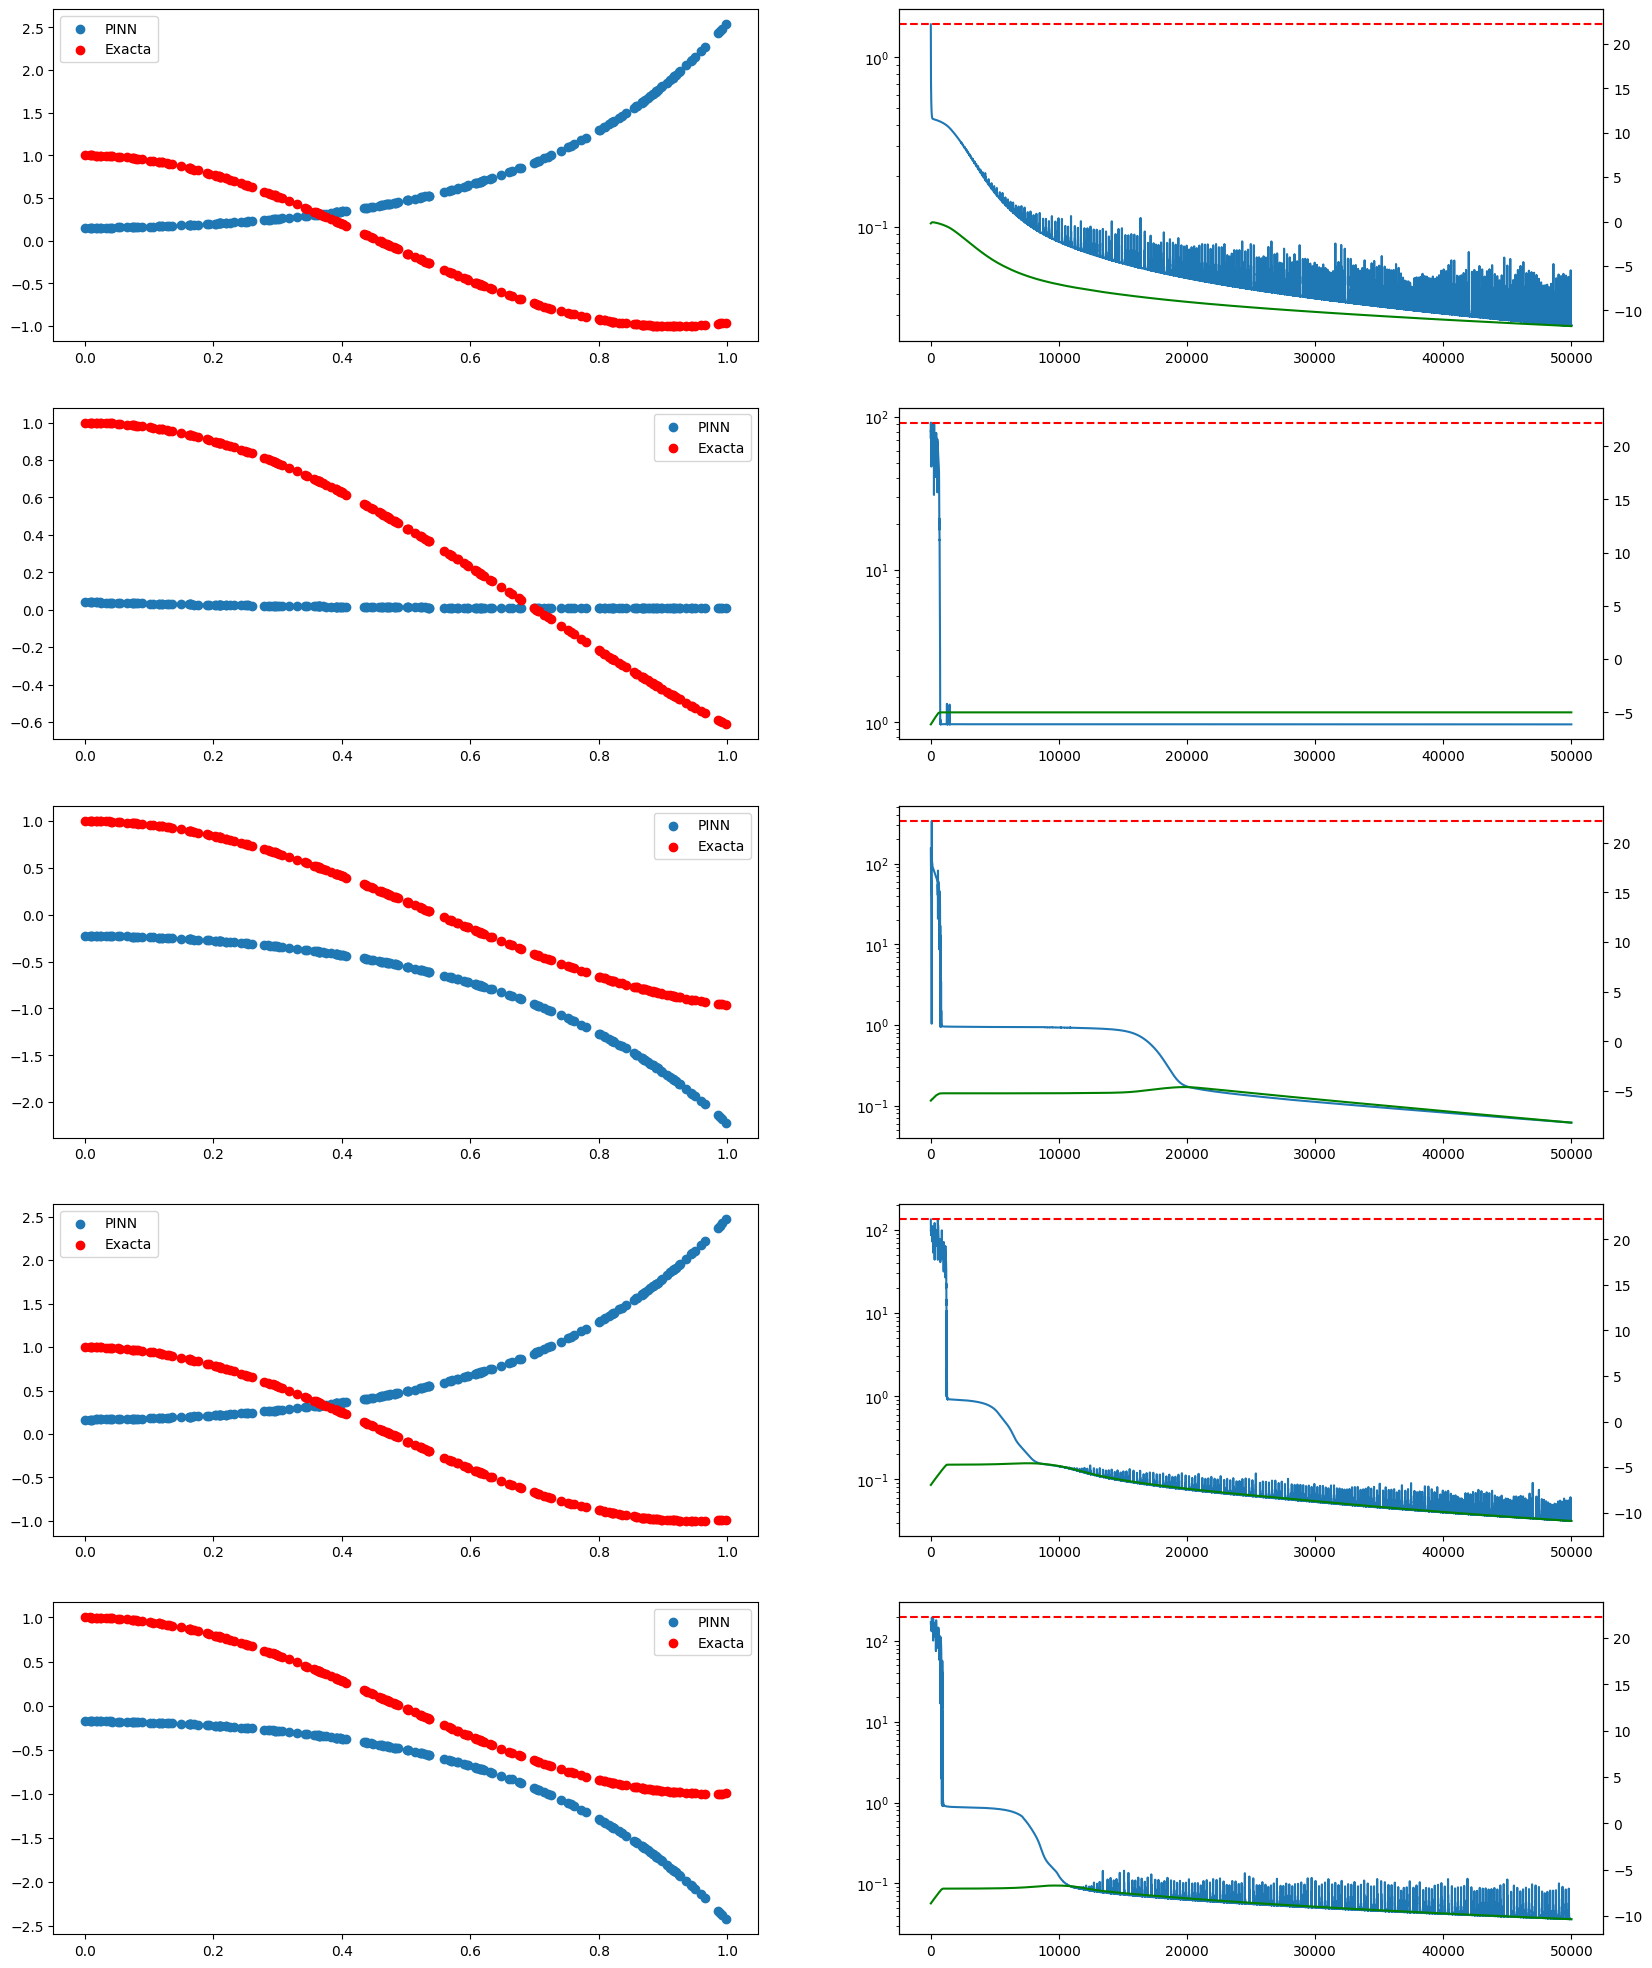

In [ ]:
# graficos
vals_g = r_vals

plt.figure(figsize=(20, M*5))

def E_n(n): 
    return ((n + 1/2)*np.pi/l)**2

def exact(x,E):
    return np.cos(np.sqrt(abs(E))*x)

for i in range(M):
    plt.subplot(M,2,2*i+1)
    #plt.title(f'E ={energias[i][0]:.4f}')
    plt.scatter(vals_g, soluciones[i], label='PINN')
    plt.scatter(vals_g, exact(vals_g, energias[i][0]), color='r', label='Exacta')
    plt.legend()

    plt.subplot(M,2,2+2*i)
    plt.plot(range(epocs), loses[i])
    plt.yscale('log')
    plt.twinx()
    plt.plot(range(epocs), E_historial[i], color='green')    
    plt.axhline(y=E_n(1), color='r', linestyle='--', label='y = 0.5')
    #plt.axhline(y=E_n(2), color='r', linestyle='--', label='y = 0.5')
    #plt.axhline(y=E_n(3), color='r', linestyle='--', label='y = 0.5')
    #plt.axhline(y=E_n(4), color='r', linestyle='--', label='y = 0.5')